This notebook is a basic introduction to the functions available in the slab2.0 library.  To run this notebook you will need to install a couple of other packages:
 - *pip install git+git://github.com/usgs/libcomcat.git*
 - *pip install git+git://github.com/usgs/neicio.git*


The cell "magic" below indicates to IPython that all plots should be rendered *inline* - that is, not in a separate window.

In [1]:
%matplotlib inline

In [2]:
#stdlib imports
from datetime import datetime
import urllib2
import os.path

#usgs imports
from slab2.slabutils import getEventsInCircle
from slab2.slabutils import getEventsInEllipse
from slab2.slabutils import heading
from libcomcat.comcat import getEventData,getTimeSegments
from neicio.gmt import GMTGrid

#third party imports
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython.display import Image
from scipy.io import netcdf
import math

Create a grid coarsely replicating the Izu-Bonin slab grid:
http://earthquake.usgs.gov/data/slab/images/izu_slab1.jpg

In [3]:
Image(url='http://earthquake.usgs.gov/data/slab/images/izu_slab1.jpg')

Go fetch this depth grid from the USGS web site:

In [4]:
url = 'http://earthquake.usgs.gov/data/slab/models/izu_slab1.0_clip.grd'
fname = 'izu_slab1.0_clip.grd'
if not os.path.isfile(fname):
    fh = urllib2.urlopen(url)
    data = fh.read()
    fh.close()
    f = open(fname,'wb')
    f.write(data)
    f.close()

depgrid = GMTGrid(fname)
xmin,xmax,ymin,ymax = depgrid.getRange()
#create arrays of lat/lon values
lons = np.arange(xmin,xmax,0.5)
lats = np.arange(ymin,ymax,0.5)
bounds = (lons.min(),lons.max(),lats.min(),lats.max())
print bounds

(129.0, 147.5, 11.0, 39.5)


In [5]:
url = 'http://earthquake.usgs.gov/data/slab/models/izu_slab1.0_strclip.grd'
fname = 'izu_slab1.0_strclip.grd'
if not os.path.isfile(fname):
    fh = urllib2.urlopen(url)
    data = fh.read()
    fh.close()
    f = open(fname,'wb')
    f.write(data)
    f.close()

strgrid = GMTGrid(fname)

url = 'http://earthquake.usgs.gov/data/slab/models/izu_slab1.0_dipclip.grd'
fname = 'izu_slab1.0_dipclip.grd'
if not os.path.isfile(fname):
    fh = urllib2.urlopen(url)
    data = fh.read()
    fh.close()
    f = open(fname,'wb')
    f.write(data)
    f.close()

dipgrid = GMTGrid(fname)

Search ComCat for recent events inside the rectangle defined by the arrays above.

In [11]:
starttime = datetime(2000,1,1)
endtime = datetime.utcnow()
magrange = (4.0,10)
tmpeventlist,maxmags = getEventData(bounds = bounds,starttime = starttime,
                         endtime = endtime,magrange=magrange)
print '%i events inside Izu-Bonin slab region.' % len(tmpeventlist)

#Because tmpeventlist is now a complicated dictionary, we have to filter it a little bit
#so it will work with getEventsInCircle and getEventsInEllipse.
eventlist = []
for event in tmpeventlist:
    newdict = {}
    for key,value in event.iteritems():
        newvalue = value[0]
        newdict[key] = newvalue
    eventlist.append(newdict.copy())
        

19534 events inside Izu-Bonin slab region.


Create two depth grids, fill them with NaN values.

In [12]:
nrows = len(lats)
ncols = len(lons)
depths = np.ones((nrows,ncols))*np.NaN
hdepths = np.ones((nrows,ncols))*np.NaN
samples = np.ones((nrows,ncols))*np.NaN
print 'Output grids will have %i rows, %i columns' % (nrows,ncols)

Output grids will have 58 rows, 38 columns


One of our two grids will be filled with a filtered mean - below we are testing the assumption of normality.  The plots below look to be either normal or binomial depending on the location chosen.

Depth =  -245.959
Strike =  159.813
Dip =  -64.969
Ellipse axes: a =  100 b =  20
Original Eventlist size =  19534
Elist size =  153
Ellipse Focus:  28.1554293783 140.352004461
Elist2 size =  8


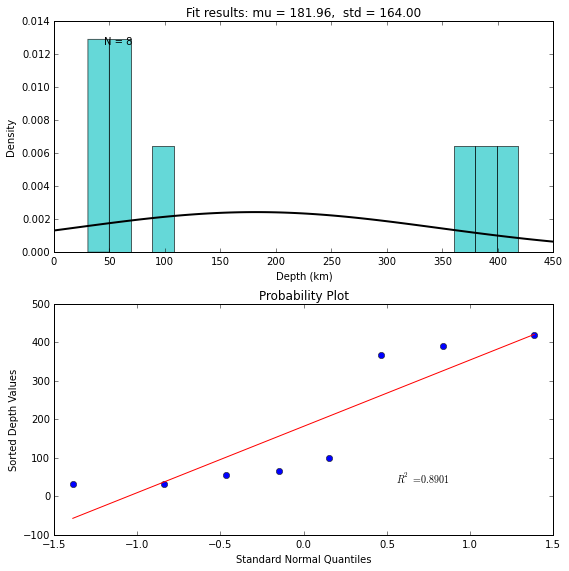

In [13]:
#choose a spot in the middle of the slab to search for events
tlat = 29.0;tlon = 140.0 #pretty binomial
#tlat = 36.0;tlon = 141.0 #fairly normal
# Define radial search parameters
radius=100
# Define ellipsoid search parameters
alen=radius
blen=radius/5

print 'Depth = ', depgrid.getValue(tlat,tlon)
cstr = strgrid.getValue(tlat,tlon)
print 'Strike = ', cstr
print 'Dip = ', dipgrid.getValue(tlat,tlon)

print 'Ellipse axes: a = ', alen, 'b = ', blen

print 'Original Eventlist size = ', len(eventlist)
elist = getEventsInCircle(tlat,tlon,radius,eventlist)
print 'Elist size = ', len(elist)

erta = math.sqrt(1-((math.pow(blen,2))/(math.pow(alen,2))))
mdist = alen*erta
#cstr2 = cstr+180
if(mdist>0):
    (rlat,rlon) = heading(tlat,tlon,alen,cstr)
else:
    rlat=tlat
    rlon=tlon
    
print 'Ellipse Focus: ',rlat,rlon

elist2 = getEventsInEllipse(rlat,rlon,cstr,alen,blen,elist)
print 'Elist2 size = ', len(elist2)

adepths = np.array([e['depth'] for e in elist2])
mu, std = stats.norm.fit(adepths)
hrange = (adepths.min(),adepths.max())

fig,axeslist = plt.subplots(nrows=2,ncols=1)
fig.set_size_inches(10,6)
plt.sca(axeslist[0])
ahist=plt.hist(adepths, bins=20, normed=True, alpha=0.6, color='c',range=hrange)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2);
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
th=plt.title(title);
xh=plt.xlabel('Depth (km)');
yh=plt.ylabel('Density');
axlim = plt.axis()
xloc = (axlim[1] - axlim[0])/10.0
yloc = axlim[3] - (axlim[3] - axlim[2])/10.0
plt.text(xloc,yloc,'N = %i' % len(adepths));

plt.sca(axeslist[1])
qqdata = stats.probplot(adepths, dist="norm",plot=plt,fit=False)
xh=plt.xlabel('Standard Normal Quantiles')
yh=plt.ylabel('Sorted Depth Values')
fig=plt.gcf()
fig.set_size_inches(8,8)

fig.tight_layout()

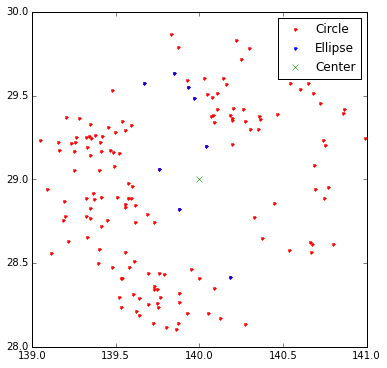

In [15]:
#plot the points we found from the circle search
fig = plt.figure(figsize=(6,6))
elat = [e['lat'] for e in elist]
elon = [e['lon'] for e in elist]
plt.plot(elon,elat,'r.');
plt.hold(True);
plt.plot()

#plot those found in ellipse
elat2 = [e['lat'] for e in elist2]
elon2 = [e['lon'] for e in elist2]
plt.plot(elon2,elat2,'b.');

plt.plot(tlon,tlat,'gx');
plt.legend(['Circle','Ellipse','Center'],numpoints=1); #don't know why this is double plotting symbols

In [16]:
tstart = datetime.now()
radius = 100
for i in range(0,len(lats)):
    for j in range(0,len(lons)):
        elat = lats[i]
        elon = lons[j]
        elist = getEventsInCircle(elat,elon,radius,eventlist)
        alldepths = np.array([e['depth'] for e in elist])
        alldepths = alldepths[np.isfinite(alldepths)]
        if len(alldepths):
            depmean = np.nanmean(alldepths)
            mu, std = stats.norm.fit(alldepths)
            minmag = mu-std
            maxmag = mu+std
            filtdepths = alldepths[(alldepths >= minmag) & (alldepths <= maxmag)]
            fdepmean = np.nanmean(filtdepths)
        else:
            depmean = np.NaN
            fdepmean = np.NaN
        depths[i,j] = depmean
        hdepths[i,j] = fdepmean
        samples[i,j] = len(alldepths)
tend = datetime.now()
print 'Creating mean depth grid for %i cells took %.1f seconds' % (nrows*ncols,(tend-tstart).seconds)

Creating mean depth grid for 2204 cells took 722.0 seconds


/Users/mhearne/anaconda/lib/python2.7/site-packages/neicmap/distance.py:57: RuntimeWarning: invalid value encountered in arcsin
  A = numpy.arcsin(numpy.cos(lat2)*numpy.sin((lon2-lon1))/numpy.sin(c))


Our depth grid is upside down in the geographical sense - use the Numpy flipud() function to fix that.

In [17]:
depths = np.flipud(depths)
hdepths = np.flipud(hdepths)

In [18]:
def getticks(lats,lons,ylocs,xlocs):
    newxlabels = []
    for loc in xlocs:
        if loc < 0:
            newxlabels.append('')
            continue
        if loc >= ncols:
            newxlabels.append('')
            continue
        newxlabels.append('%.1f' % lons[int(loc)])
    newylabels = []
    rlats = lats[-1:0:-1]
    for loc in ylocs:
        if loc < 0:
            newylabels.append('')
            continue
        if loc >= nrows:
            newylabels.append('')
            continue
        newylabels.append('%.1f' % rlats[int(loc)])   
    return (newylabels,newxlabels)

9.05 530.3


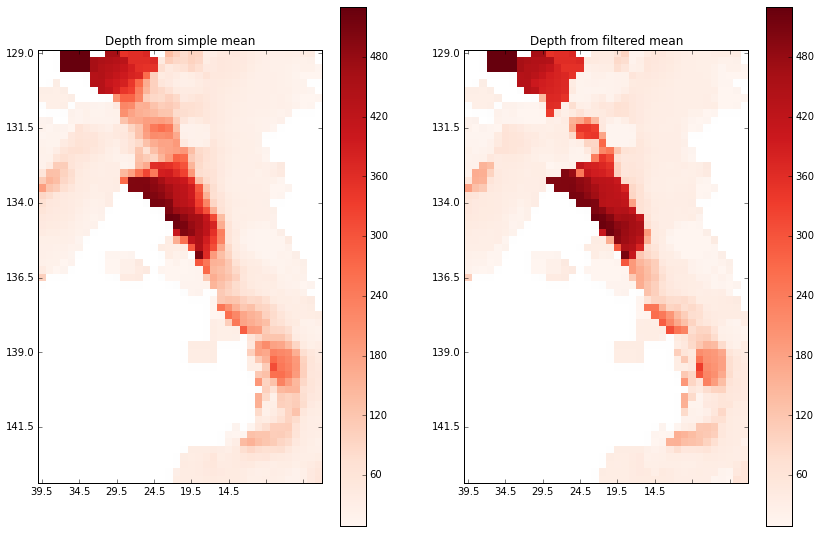

In [19]:
dmin = min(np.nanmin(depths),np.nanmin(hdepths))
dmax = max(np.nanmax(depths),np.nanmax(hdepths))
print dmin,dmax
cmap = 'Reds'
shrink = 0.93
fig,axeslist = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(14, 10)
plt.sca(axeslist[0])
plt.imshow(depths,cmap=cmap,interpolation='none',vmin=dmin,vmax=dmax);
plt.colorbar(shrink=shrink);
xlocs,xlabels = plt.xticks();
ylocs,ylabels = plt.yticks();
xlabels,ylabels = getticks(lats,lons,ylocs,xlocs);
axlim = plt.axis();
plt.xticks(xlocs,xlabels);
plt.yticks(ylocs,ylabels);
axlim = plt.axis(axlim);
plt.title('Depth from simple mean');

plt.sca(axeslist[1])
plt.imshow(hdepths,cmap=cmap,interpolation='none',vmin=dmin,vmax=dmax);
plt.colorbar(shrink=shrink);
xlocs,xlabels = plt.xticks();
ylocs,ylabels = plt.yticks();
xlabels,ylabels = getticks(lats,lons,ylocs,xlocs);
axlim = plt.axis();
plt.xticks(xlocs,xlabels);
plt.yticks(ylocs,ylabels);
axlim = plt.axis(axlim);
plt.title('Depth from filtered mean');